In [1]:
import IPython
import IPython.display
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
torch.set_printoptions(linewidth=120)

from sklearn.metrics import confusion_matrix

import time
import itertools
from itertools import product
from collections import OrderedDict, namedtuple
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) Input Layer
        t = t
        # (2) Hidden Conv Layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # (3) Hidden Conv Layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # (4) Hidden Linear Layer
        t = t.reshape(-1, 12 * 4 * 4)
        t = self.fc1(t)
        t = F.relu(t)
        # (5) Hidden Linear Layer
        t = self.fc2(t)
        t = F.relu(t)
        # (6) Out Layer
        t = self.out(t)
        #t = F.softmax(t, dim=1) # used for single class classification problems
        return t
       
    def fit(self, network, train_set, epochs=10, batches=1000, learning_rate=0.01, num_workers=2):
        train_loader = torch.utils.data.DataLoader(train_set,batch_size = batches,
                                                   shuffle = True,num_workers = num_workers)
        train_loader = train_loader
        optimizer = optim.Adam(network.parameters(), lr = learning_rate)
        accuracy = 0
        comment = f' batch_size={batches} lr={learning_rate}'
        tb = SummaryWriter(comment=comment)
        images, label = next(iter(train_loader))
        grid = torchvision.utils.make_grid(images)
        tb.add_image('images', grid)
        tb.add_graph(network, images)
        for epoch in range(epochs):
            total_loss = 0
            total_correct = 0
            for batch in train_loader: # Get Batch
                images, labels = batch
                preds = network(images) #Pass Batch
                loss = F.cross_entropy(preds, labels) #Claculate Loss
                optimizer.zero_grad() #replace the Gradient instead of summing up
                loss.backward() #Calculate Gradient
                optimizer.step() #Update Weights
                total_loss += loss.item() * batches
                total_correct += get_num_correct(preds, labels)
                floss = total_loss/len(train_set)
                accuracy = total_correct/len(train_set)
            tb.add_scalar('Loss', floss, epoch)
            tb.add_scalar('Accuracy', accuracy, epoch)
            for name, weight in network.named_parameters():
                tb.add_histogram(name, weight, epoch)
                tb.add_histogram(f'{name}.grad',weight.grad,epoch)
            print("epoch: ", epoch, "loss: ", floss, "accuracy: ", accuracy)
        tb.close() 

In [3]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.Tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

def get_confusion_matrix(model,loader,train_set):
    preds = get_all_preds(model, loader)
    train_targets = train_set.targets
    num_targets = train_targets.unique().shape
    train_preds = preds.argmax(dim=1)
    cm = confusion_matrix(train_targets, train_preds)
    return cm

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_cm(cm, names):
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(cm, names)

epoch:  0 loss:  1.0648401061693826 accuracy:  0.5813666666666667
epoch:  1 loss:  0.5725023955106735 accuracy:  0.77455
epoch:  2 loss:  0.4864492192864418 accuracy:  0.8159666666666666
epoch:  3 loss:  0.42772547552982965 accuracy:  0.8422833333333334
epoch:  4 loss:  0.38771034926176073 accuracy:  0.85855
epoch:  5 loss:  0.3628377248843511 accuracy:  0.8668166666666667
epoch:  6 loss:  0.3357147604227066 accuracy:  0.8759666666666667
epoch:  7 loss:  0.32398213595151903 accuracy:  0.8806166666666667
epoch:  8 loss:  0.3166683798034986 accuracy:  0.8832
epoch:  9 loss:  0.3042032872637113 accuracy:  0.8862166666666667
Confusion matrix, without normalization
[[5005    7   52  150   42    2  713    0   29    0]
 [   3 5885    5   86   12    0    7    0    2    0]
 [  91    8 4737   39  705    0  412    0    8    0]
 [ 139   26   16 5347  330    0  139    0    3    0]
 [   6    7  229  118 5394    1  239    0    6    0]
 [   1    0    0    1    0 5838    0  136    1   23]
 [ 639    6  

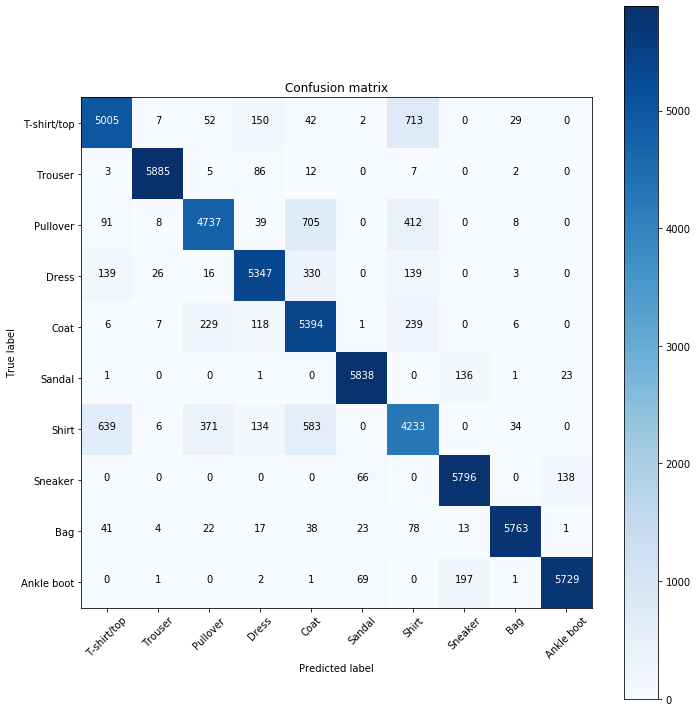

In [4]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',train = True,download = True,
    transform = transforms.Compose([transforms.ToTensor()])
)

network = Network()

names = (
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
)
train_loader = torch.utils.data.DataLoader(train_set,batch_size = 1000,num_workers = 2) #not shuffling for confusion matrix purposes
network.fit(network, train_set, epochs=10)
cm = get_confusion_matrix(network, train_loader, train_set)
plot_cm(cm, names)

In [5]:
class RunBuilder():
    @staticmethod
    def get_runs(params):
        #Run receives a named tuple of parameter dict keys
        Run = namedtuple('Run', params.keys())
        
        runs = []
        #For each cartesian product between the values of the parameters dict keys 
        #build a list of runs following the named tuple structure above defined
        for v in product(*params.values()):
            runs.append(Run(*v))
        
        return runs

class Epoch():
    def __init__(self):
        self.count = 0
        self.loss = 0
        self.num_correct = 0
        self.start_time = None

class Run():
    def __init__(self):
        self.params = None
        self.count = 0
        self.data = []
        self.start_time = None

    
class RunManager():
    def __init__(self):
        self.epoch = Epoch()
        self.run = Run()
        self.network = None
        self.loader = None
        self.tb = None
    
    def begin_run(self, run, network, loader):
        self.run.start_time = time.time()
        self.run.params = run
        self.run.count += 1
        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment=f'-{run}')
        images, labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)
        self.tb.add_image('images', grid)
        self.tb.add_graph(self.network, images)
        
    def end_run(self):
        self.tb.close()
        self.epoch.count = 0
    
    def begin_epoch(self):
        self.epoch.start_time = time.time()
        self.epoch.count += 1
        self.epoch.loss = 0
        self.epoch.num_correct = 0
        
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch.start_time
        run_duration = time.time() - self.run.start_time
        loss = self.epoch.loss / len(self.loader.dataset)
        accuracy = self.epoch.num_correct / len(self.loader.dataset)
        self.tb.add_scalar('Loss', loss, self.epoch.count)
        self.tb.add_scalar('Accuracy', accuracy, self.epoch.count)
        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch.count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch.count)
        results = OrderedDict()
        results["run"] = self.run.count
        results["epoch"] = self.epoch.count
        results["loss"] = loss
        results["accuracy"] = accuracy
        results["epoch_duration"] = epoch_duration
        results["run_duration"] = run_duration
        for k,v in self.run.params._asdict().items(): results[k] = v
        self.run.data.append(results)
        df = pd.DataFrame.from_dict(self.run.data, orient='columns')
        IPython.display.clear_output(wait=True)
        display(df)
    
    def track_loss(self,loss):
        self.epoch.loss += loss.item() * self.loader.batch_size
        
    def track_num_correct(self, preds, labels):
        self.epoch.num_correct += self._get_num_correct(preds, labels)
        
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self, filename):
        pd.DataFrame.from_dict(self.run.data,orient='columns').to_csv(f'{filename}.csv')
        with open(f'{filename}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run.data, f, ensure_ascii=False, indent=4)
        
        

In [6]:
params = OrderedDict(
    lr = [0.01], # tested between 0.01, 0.001, the best one was 0.01
    batch_size = [1000], # after trying against 10, 100 and 1000, 1000 gave the best result
    epoch = [10], # after trying against 5, 10, 100 the 10 gave an acceptable wait time, and good accuracy not to overfit nor underfit
    shuffle = [True], #Needed always 
    num_workers = [2] # after some runs, 2 is the ideal number
)

m = RunManager()
for run in RunBuilder.get_runs(params):
    network = Network()
    loader = DataLoader(
        train_set, 
        batch_size = run.batch_size, 
        shuffle = run.shuffle,
        num_workers = run.num_workers
    )
    optimizer = optim.Adam(network.parameters(), lr=run.lr)
    m.begin_run(run, network, loader)
    for epoch in range(run.epoch):
        m.begin_epoch()
        for batch in loader:
            images = batch[0]
            labels = batch[1]
            preds = network(images) # Pass Batch
            loss = F.cross_entropy(preds, labels) # Calculate Loss
            optimizer.zero_grad() # Zero Gradients
            loss.backward() # Calculate Gradients
            optimizer.step() # Update Weights
            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        m.end_epoch()
    m.end_run()
m.save('results')

,run,epoch,loss,accuracy,epoch_duration,run_duration,lr,batch_size,shuffle,num_workers
0,1,10,0.941449,0.649050,13.501123,14.856279,0.01,1000,True,2
1,1,10,0.493684,0.811133,13.776082,28.738991,0.01,1000,True,2
2,1,10,0.421380,0.843933,13.920605,42.751448,0.01,1000,True,2
3,1,10,0.368147,0.865317,13.836341,56.686145,0.01,1000,True,2
4,1,10,0.348513,0.871933,13.454502,70.237525,0.01,1000,True,2
5,1,10,0.325703,0.880117,13.720769,84.062271,0.01,1000,True,2
6,1,10,0.309921,0.885967,13.552314,97.714365,0.01,1000,True,2
7,1,10,0.294222,0.891500,13.795509,111.603566,0.01,1000,True,2
8,1,10,0.283786,0.894950,13.523788,125.221051,0.01,1000,True,2
9,1,10,0.274264,0.897767,13.609454,138.928147,0.01,1000,True,2
